<a href="https://colab.research.google.com/github/deekshagowri/Powerpluse_houselhold_energy_uasage/blob/main/power_usage.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import pandas as pd
import numpy as np

# Download dataset
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/00235/household_power_consumption.zip
!unzip household_power_consumption.zip

# Read the data
df = pd.read_csv('household_power_consumption.txt', sep=';',
                 na_values=['?', 'nan', 'NaN', ''])

print("Initial data shape:", df.shape)
print("\nMissing values before cleaning:")
print(df.isnull().sum())

# Convert date and time columns to datetime
df['datetime'] = pd.to_datetime(df['Date'] + ' ' + df['Time'])
df.drop(['Date', 'Time'], axis=1, inplace=True)

# Convert numeric columns
numeric_columns = ['Global_active_power', 'Global_reactive_power', 'Voltage',
                  'Global_intensity', 'Sub_metering_1', 'Sub_metering_2', 'Sub_metering_3']

for col in numeric_columns:
    df[col] = pd.to_numeric(df[col], errors='coerce')
    # Fill NaN with median
    df[col].fillna(df[col].median(), inplace=True)

# Create basic time features
df['hour'] = df['datetime'].dt.hour
df['day_of_week'] = df['datetime'].dt.dayofweek
df['month'] = df['datetime'].dt.month
df['year'] = df['datetime'].dt.year
df['is_weekend'] = df['day_of_week'].isin([5, 6]).astype(int)

print("\nFinal data shape:", df.shape)
print("\nMissing values after cleaning:")
print(df.isnull().sum())

# Save processed data
df.to_csv('processed_power_data.csv', index=False)
print("\nProcessed data saved to 'processed_power_data.csv'")

--2025-02-10 15:36:23--  https://archive.ics.uci.edu/ml/machine-learning-databases/00235/household_power_consumption.zip
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified
Saving to: ‘household_power_consumption.zip’

household_power_con     [    <=>             ]  19.68M  27.0MB/s    in 0.7s    

2025-02-10 15:36:24 (27.0 MB/s) - ‘household_power_consumption.zip’ saved [20640916]

Archive:  household_power_consumption.zip
  inflating: household_power_consumption.txt  
Initial data shape: (2075259, 9)

Missing values before cleaning:
Date                         0
Time                         0
Global_active_power      25979
Global_reactive_power    25979
Voltage                  25979
Global_intensity         25979
Sub_metering_1           25979
Sub_metering_2           25979
Sub_metering_3           25979
dtype

<ipython-input-2-113725d35deb>:17: UserWarning: Parsing dates in %d/%m/%Y %H:%M:%S format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df['datetime'] = pd.to_datetime(df['Date'] + ' ' + df['Time'])
<ipython-input-2-113725d35deb>:27: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].fillna(df[col].median(), inplace=True)



Final data shape: (2075259, 13)

Missing values after cleaning:
Global_active_power      0
Global_reactive_power    0
Voltage                  0
Global_intensity         0
Sub_metering_1           0
Sub_metering_2           0
Sub_metering_3           0
datetime                 0
hour                     0
day_of_week              0
month                    0
year                     0
is_weekend               0
dtype: int64

Processed data saved to 'processed_power_data.csv'


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [3]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

def load_and_clean_data():
    """Load and clean the dataset with efficient handling of missing values."""
    # Read only the necessary columns to improve loading speed
    df = pd.read_csv('household_power_consumption.txt', sep=';',
                     usecols=['Date', 'Time', 'Global_active_power', 'Global_reactive_power',
                             'Voltage', 'Global_intensity', 'Sub_metering_1',
                             'Sub_metering_2', 'Sub_metering_3'],
                     na_values=['?'])

    # Convert Date and Time to datetime efficiently
    df['datetime'] = pd.to_datetime(df['Date'] + ' ' + df['Time'])
    df.drop(['Date', 'Time'], axis=1, inplace=True)

    # Convert numeric columns and handle missing values efficiently
    numeric_columns = df.columns.drop('datetime')
    df[numeric_columns] = df[numeric_columns].apply(pd.to_numeric, errors='coerce')

    # Fill missing values with median
    df[numeric_columns] = df[numeric_columns].fillna(df[numeric_columns].median())

    return df

def create_essential_features(df):
    """Create only the most important features for prediction."""
    # Add basic time features
    df['hour'] = df['datetime'].dt.hour
    df['day_of_week'] = df['datetime'].dt.dayofweek

    # Calculate non-measured energy
    df['non_measured_energy'] = (df['Global_active_power'] * 1000/60 -
                                df['Sub_metering_1'] - df['Sub_metering_2'] -
                                df['Sub_metering_3'])

    return df

def prepare_modeling_data(df):
    """Prepare data for modeling with essential features only."""
    feature_columns = ['Global_reactive_power', 'Voltage', 'Global_intensity',
                      'Sub_metering_1', 'Sub_metering_2', 'Sub_metering_3',
                      'hour', 'day_of_week', 'non_measured_energy']

    X = df[feature_columns]
    y = df['Global_active_power']

    return X, y

def evaluate_models(X, y):
    """Evaluate models with optimized parameters for faster execution."""
    # Split data with a smaller test size for faster evaluation
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

    # Scale the features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Initialize models with optimized parameters
    models = {
        "Linear Regression": LinearRegression(),
        "Random Forest Regressor": RandomForestRegressor(
            n_estimators=50,  # Reduced number of trees
            max_depth=10,     # Limited depth
            n_jobs=-1,        # Parallel processing
            random_state=42
        ),
        "Gradient Boosting Regressor": GradientBoostingRegressor(
            n_estimators=50,  # Reduced number of trees
            max_depth=5,      # Limited depth
            random_state=42
        )
    }

    results = {}
    best_rmse = float('inf')
    best_model = None

    # Evaluate each model
    for name, model in models.items():
        # Train and predict
        model.fit(X_train_scaled, y_train)
        y_pred = model.predict(X_test_scaled)

        # Calculate metrics
        rmse = np.sqrt(mean_squared_error(y_test, y_pred))
        mae = mean_absolute_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)

        results[name] = {
            "RMSE": rmse,
            "MAE": mae,
            "R-squared (R²)": r2
        }

        # Track best model
        if rmse < best_rmse:
            best_rmse = rmse
            best_model = name

    # Print results in the desired format
    print("\nModel Evaluation Results:")
    for name, metrics in results.items():
        print(f"{name}:")
        for metric, value in metrics.items():
            print(f"{metric}: {value}")

    print(f"\nThe best-performing model is: {best_model}")

    return results, best_model

def main():
    try:
        # Load and process data
        df = load_and_clean_data()
        df = create_essential_features(df)

        # Prepare for modeling
        X, y = prepare_modeling_data(df)

        # Evaluate models
        results, best_model = evaluate_models(X, y)

    except Exception as e:
        print(f"An error occurred: {str(e)}")

if __name__ == "__main__":
    main()

<ipython-input-3-6b2de0fd86de>:19: UserWarning: Parsing dates in %d/%m/%Y %H:%M:%S format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df['datetime'] = pd.to_datetime(df['Date'] + ' ' + df['Time'])



Model Evaluation Results:
Linear Regression:
RMSE: 2.0925993886465472e-15
MAE: 1.5779955407542605e-15
R-squared (R²): 1.0
Random Forest Regressor:
RMSE: 0.03143795448135628
MAE: 0.01655111472573971
R-squared (R²): 0.9991097761658025
Gradient Boosting Regressor:
RMSE: 0.031078821747925343
MAE: 0.018973206570499248
R-squared (R²): 0.9991299990093458

The best-performing model is: Linear Regression


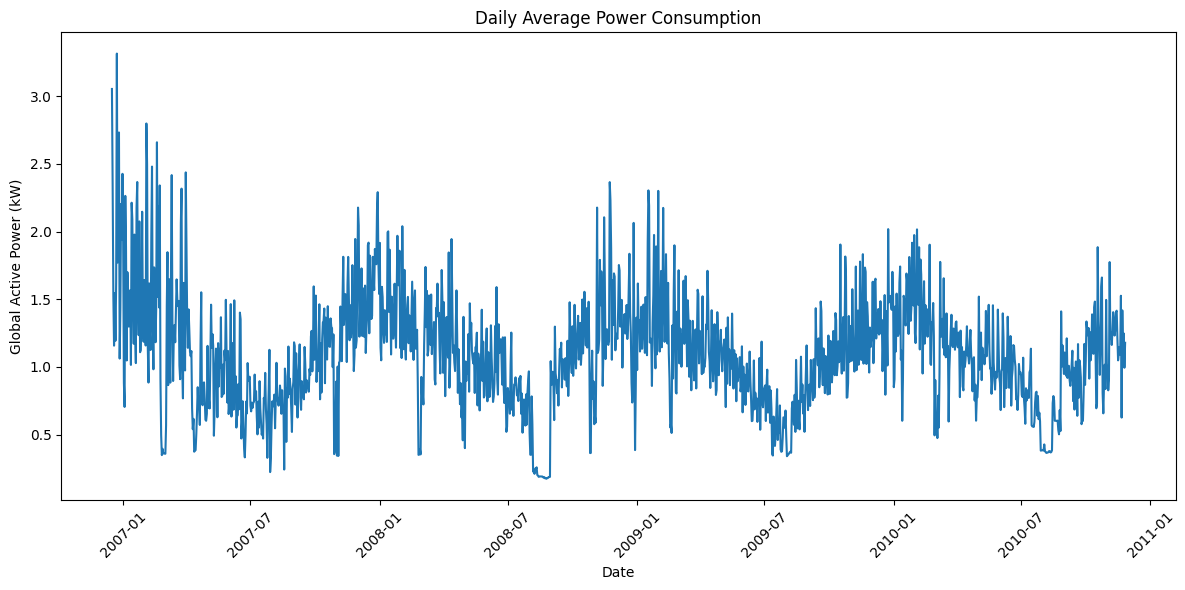

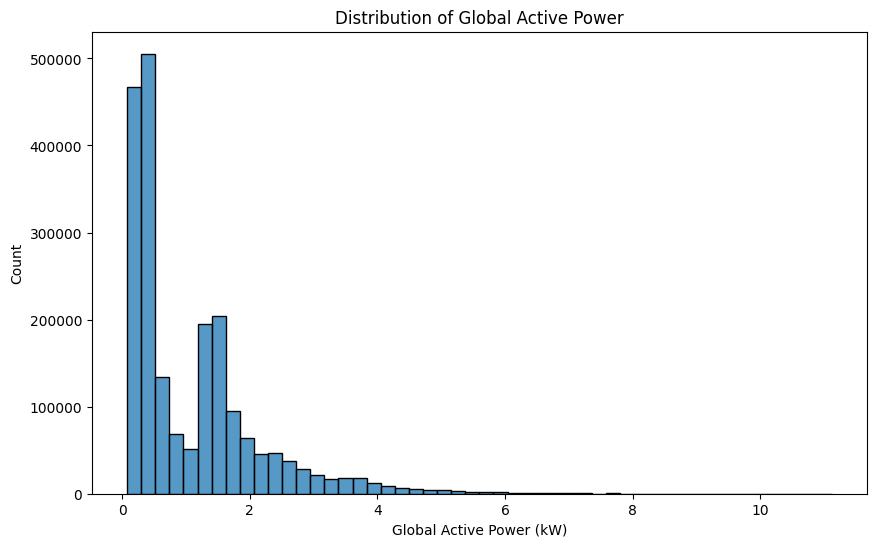

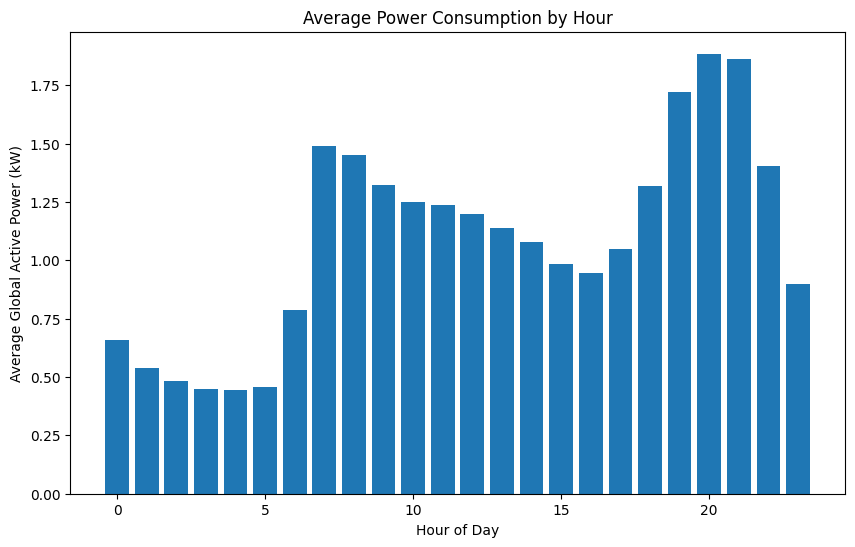

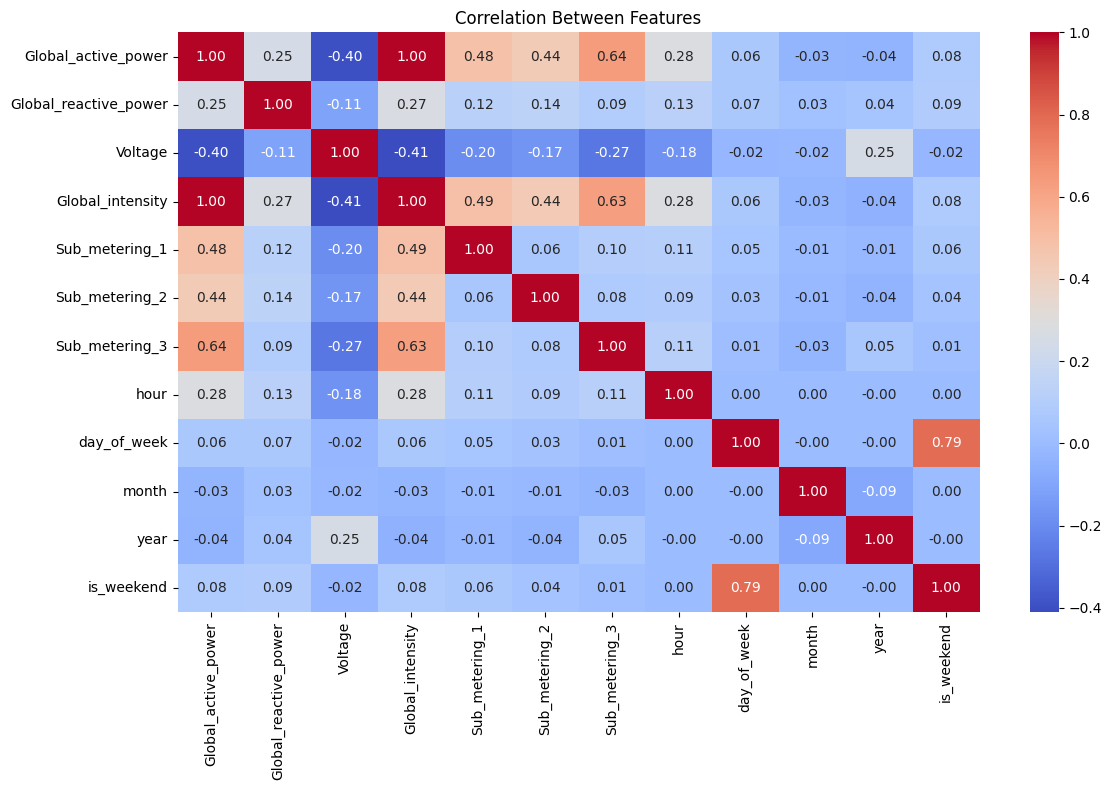

In [5]:
#Data Visualization
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Read the processed data
df = pd.read_csv('processed_power_data.csv')
df['datetime'] = pd.to_datetime(df['datetime'])

# 1. Daily Power Consumption
plt.figure(figsize=(12, 6))
daily_power = df.groupby(df['datetime'].dt.date)['Global_active_power'].mean()
plt.plot(daily_power.index, daily_power.values)
plt.title('Daily Average Power Consumption')
plt.xlabel('Date')
plt.ylabel('Global Active Power (kW)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# 2. Distribution of Power Consumption
plt.figure(figsize=(10, 6))
sns.histplot(data=df, x='Global_active_power', bins=50)
plt.title('Distribution of Global Active Power')
plt.xlabel('Global Active Power (kW)')
plt.ylabel('Count')
plt.show()

# 3. Power Consumption by Hour
plt.figure(figsize=(10, 6))
hourly_avg = df.groupby('hour')['Global_active_power'].mean()
plt.bar(hourly_avg.index, hourly_avg.values)
plt.title('Average Power Consumption by Hour')
plt.xlabel('Hour of Day')
plt.ylabel('Average Global Active Power (kW)')
plt.show()

# 4. Correlation Heatmap
plt.figure(figsize=(12, 8))
numeric_cols = df.select_dtypes(include=[np.number]).columns
correlation = df[numeric_cols].corr()
sns.heatmap(correlation, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Between Features')
plt.tight_layout()
plt.show()
